In [1]:
import os
import re
import time

import numpy as np
import cv2

from sklearn.svm import SVC, LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [2]:
import matplotlib.image as mpimg
import numpy as np
import cv2
from skimage.feature import hog
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        if file.endswith("png"):
                image = (image * 255).astype(np.uint8)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features
    
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy


In [3]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
#from lesson_functions import *
# NOTE: the next import is only valid for scikit-learn version <= 0.17
# for scikit-learn >= 0.18 use:
# from sklearn.model_selection import train_test_split
from sklearn.cross_validation import train_test_split

# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows
    
    


D:\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [4]:
def find_all_files( _dir):
    matches = []

    img_re = re.compile(r'.+\.(jpg|png|jpeg|tif|tiff)$', re.IGNORECASE)

    for root, dirnames, filenames in os.walk(_dir):
        matches.extend(os.path.join(root, name) for name in filenames if img_re.match(name))

    return matches

cars = find_all_files("./vehicles")

notcars = find_all_files("./non-vehicles")


print(len(cars))
print(len(notcars))

9988
9367


In [217]:
# Read in cars and notcars
#car_images = glob.glob('vehicles/small_set/*.jpeg')
#car_images = glob.glob('vehicles/cars/*.jpeg')
#cars = []
#notcars = []
#for image in car_images:
#    cars.append(image)

#car_images2 = glob.glob('vehicles/small_set/*.jpeg')
    
#notcar_images = glob.glob('non-vehicles/Extras/*.png')
#notcar_images = glob.glob('non-vehicles/small_set/*.jpeg')
#for image in notcar_images:
#    notcars.append(image)

#print(len(cars))
#print(len(notcars))

In [5]:
# Reduce the sample size because
# The quiz evaluator times out after 13s of CPU time
sample_size = 6000
cars = cars[0:sample_size]
notcars = notcars[0:sample_size]

### TODO: Tweak these parameters and see how the results change.
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 16   # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [400, None] # Min and max in y to search in slide_window()

car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
print(len(car_features))

6000


In [6]:
print(len(cars))

6000


In [7]:
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

In [8]:
# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()

Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 8412
4.18 Seconds to train SVC...
Test Accuracy of SVC =  0.9912


(5.87, 'Seconds to Process')


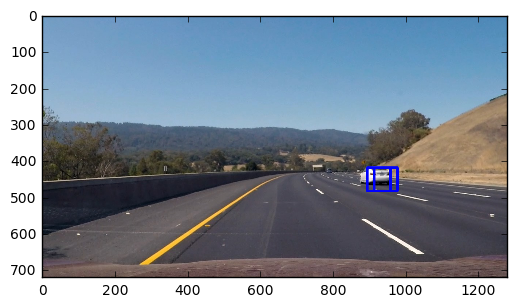

In [9]:


image = mpimg.imread('test_images/test3.jpg')
draw_image = np.copy(image)

# Uncomment the following line if you extracted training
# data from .png images (scaled 0 to 1 by mpimg) and the
# image you are searching is a .jpg (scaled 0 to 255)
#image = image.astype(np.float32)/255
t=time.time()
windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=(64, 64), xy_overlap=(0.7, 0.7))

hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)                       

window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)
t2=time.time()
print((round(t2-t, 2), 'Seconds to Process'))
plt.imshow(window_img)
plt.show()




In [10]:
def update_heatmap(candidates, image_shape, heatmap=None):
    if heatmap is None:
        heatmap = np.zeros((image_shape[0], image_shape[1]), np.uint8)

    for pt1, pt2 in candidates:
        x1, y1 = pt1
        x2, y2 = pt2
        x1 = min(max(x1, 0), image_shape[1])
        x2 = min(max(x2, 0), image_shape[1])
        y1 = min(max(y1, 0), image_shape[0])
        y2 = min(max(y2, 0), image_shape[0])
        xv, yv = np.meshgrid(range(x1, x2), range(y1, y2))

        heatmap[yv, xv] += 1

    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 3)
    # Return the image
    return img

In [11]:
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    
    heatmap[heatmap > threshold] = 1
    # Return thresholded map
    return heatmap

In [12]:
heat = np.zeros_like(draw_image[:,:,0]).astype(np.float)
heatmap = update_heatmap(hot_windows, draw_image.shape)
heatmap = apply_threshold(heatmap, 0)

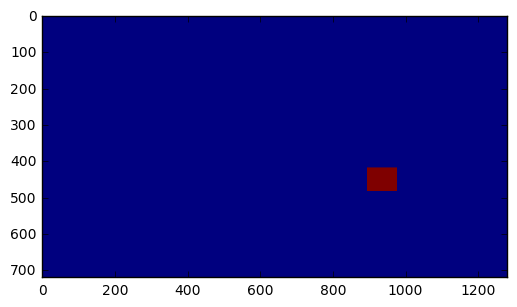

In [13]:
plt.imshow(heatmap)
plt.show()

In [14]:
from scipy.ndimage.measurements import label
labels = label(heatmap)
print(labels)


(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]]), 1)


In [15]:

def centroid(box, as_int=False):
    """
    Computes the centroid of a bounding box
    """
    x1, y1 = box[0]
    x2, y2 = box[1]
    print((int((x1+x2)//2), ((y1+y2)//2)))
    return (int((x1+x2)//2), ((y1+y2)//2))

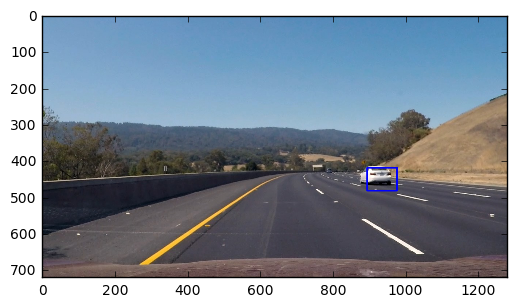

In [16]:
draw_img = draw_labeled_bboxes(np.copy(image), labels)
# Display the image
plt.imshow(draw_img)
plt.show()

In [17]:
heatmap_pre = np.zeros((image.shape[0], image.shape[1]), np.uint8)

In [18]:
def find_cars_2(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_image = np.copy(img)
    # Uncomment the following line if you extracted training
    # data from .png images (scaled 0 to 1 by mpimg) and the
    # image you are searching is a .jpg (scaled 0 to 255)
    #image = image.astype(np.float32)/255

    windows = slide_window(draw_image, x_start_stop=[None, None], y_start_stop=(ystart, ystop), 
                        xy_window=(100, 100), xy_overlap=(0.9, 0.9))

    hot_windows = search_windows(draw_image, windows, svc, X_scaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)                       

    #window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)   
    
    heatmap = np.zeros_like(draw_image[:,:,0]).astype(np.float)
    heatmap = update_heatmap(hot_windows, draw_image.shape)
   
    heatmap = apply_threshold(heatmap, 2)
    
    labels = label(heatmap)
    
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    return draw_img


(10.86, 'Seconds to Process')


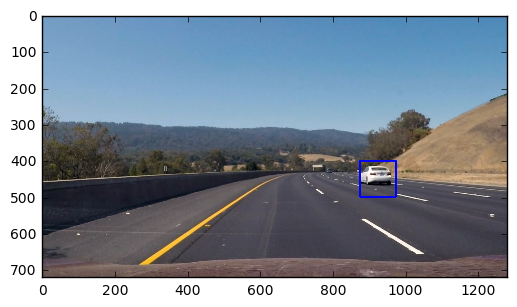

In [19]:
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [400, None] # Min and max in y to search in slide_window()

ystart = 400
ystop = 600
scale = 1.0
t=time.time()    
img = mpimg.imread('test_images/test3.jpg')
im_show = find_cars_2(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
t2=time.time()
print((round(t2-t, 2), 'Seconds to Process'))
plt.imshow(im_show)
plt.show()

In [20]:
def find_cars_3(img, ystart, ystop, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_image = np.copy(img)
    # Uncomment the following line if you extracted training
    # data from .png images (scaled 0 to 1 by mpimg) and the
    # image you are searching is a .jpg (scaled 0 to 255)
    #image = image.astype(np.float32)/255
    #t=time.time() 
    #windows0 = slide_window(draw_image, x_start_stop=[None, None], y_start_stop=(ystart, ystop), 
    #                    xy_window=(60, 60), xy_overlap=(0.3, 0.3))
    
    #windows1 = slide_window(draw_image, x_start_stop=[None, None], y_start_stop=(ystart, ystop), 
    #                    xy_window=(75, 75), xy_overlap=(0.7, 0.7))
    #
    windows1 = slide_window(draw_image, x_start_stop=[400, 1200], y_start_stop=(400, 500), 
                        xy_window=(100, 100), xy_overlap=(0.9, 0.9))
    
    #windows1_1 = slide_window(draw_image, x_start_stop=[475, 1200], y_start_stop=(400, 600), 
    #                    xy_window=(75, 75), xy_overlap=(0.6, 0.6))
    #
    #windows1_2 = slide_window(draw_image, x_start_stop=[450, 1200], y_start_stop=(400, 600), 
    #                    xy_window=(75, 75), xy_overlap=(0.6, 0.6))
    #
    windows2 = slide_window(draw_image, x_start_stop=[None, None], y_start_stop=(450, 600), 
                        xy_window=(150, 150), xy_overlap=(0.8, 0.8))
    #t2=time.time()
    #print((round(t2-t, 2), 'Seconds to Windows'))
    #hot_windows0 = search_windows(draw_image, windows0, svc, X_scaler, color_space=color_space, 
    #                        spatial_size=spatial_size, hist_bins=hist_bins, 
    #                       orient=orient, pix_per_cell=pix_per_cell, 
    #                       cell_per_block=cell_per_block, 
    #                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
    #                        hist_feat=hist_feat, hog_feat=hog_feat) 
        
    hot_windows1 = search_windows(draw_image, windows1, svc, X_scaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat) 
    hot_windows2 = search_windows(draw_image, windows2, svc, X_scaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)        
        
    #hot_windows1_1 = search_windows(draw_image, windows1_1, svc, X_scaler, color_space=color_space, 
    #                        spatial_size=spatial_size, hist_bins=hist_bins, 
    #                        orient=orient, pix_per_cell=pix_per_cell, 
    #                        cell_per_block=cell_per_block, 
    #                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
    #                        hist_feat=hist_feat, hog_feat=hog_feat) 

    #hot_windows1_2 = search_windows(draw_image, windows1_2, svc, X_scaler, color_space=color_space, 
    #                        spatial_size=spatial_size, hist_bins=hist_bins, 
    #                        orient=orient, pix_per_cell=pix_per_cell, 
    #                        cell_per_block=cell_per_block, 
    #                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
    #                        hist_feat=hist_feat, hog_feat=hog_feat) 

    #window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)   
    
    heat = np.zeros_like(draw_image[:,:,0]).astype(np.float)
    heatmap = update_heatmap(hot_windows1, draw_image.shape)
    heatmap = update_heatmap(hot_windows2, draw_image.shape,heatmap)
    #heatmap = update_heatmap(hot_windows1_1, draw_image.shape,heatmap)
    #heatmap = update_heatmap(hot_windows1_2, draw_image.shape,heatmap)
    return heatmap 

    heatmap = heatmap_new + heatmap_pre
    heatmap_pre = heatmap_new
    heatmap = apply_threshold(heatmap, 0)
    
    labels = label(heatmap)
    
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    return draw_img


(1.18, 'Seconds to Process')


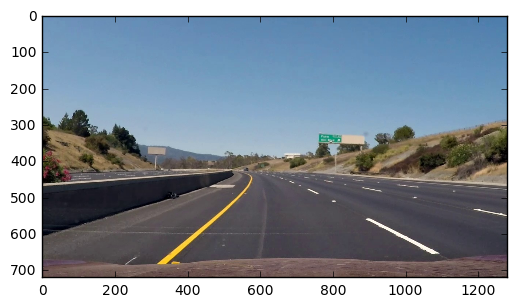

In [21]:
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [400, None] # Min and max in y to search in slide_window()

ystart = 400
ystop = 600
scale = 1.0
t=time.time()    
img = mpimg.imread('test_images/frame2.jpg')

heatmap = find_cars_3(img, ystart, ystop,  svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
heatmap = apply_threshold(heatmap, 1)

labels = label(heatmap)

draw_img = draw_labeled_bboxes(np.copy(img), labels)

t2=time.time()
print((round(t2-t, 2), 'Seconds to Process'))
plt.imshow(draw_img)
plt.show()

0
25
50
75
100
125
150
175
200
225
250
275
300
325
350
375
400
425
450
475
500
525
550
575
600
625
650
675
700
701
(0.82, 'Seconds to Process')


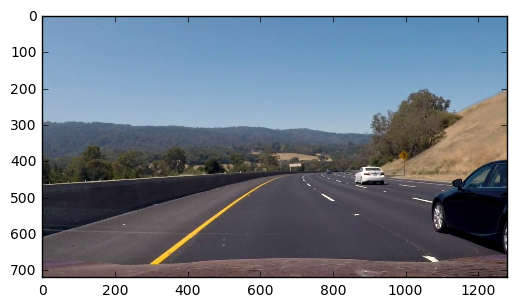

In [26]:
vidcap = cv2.VideoCapture('project_video.mp4')
success,img = vidcap.read()
ystart = 400
ystop = 600
count = 0
success = True
image_out_arr=[]
heatmap_pre = np.zeros((image.shape[0], image.shape[1]), np.uint8)
while success:
    #print(count)
    success,img2 = vidcap.read()
    if(count%25 == 0):
        print(count)
    if success== True and count > (700):
        
        print(count)
        img3 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
        #cv2.imwrite('test630.jpg',img3)
        #img = mpimg.imread('test_images/test630.jpg')
        #img_dif = img2-img
        #cv2.imwrite('output_images/frame'+str(count)+'.jpg',img2)
        t=time.time() 
        
        heatmap = find_cars_3(img3, ystart, ystop,  svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
        
        #plt.imshow(heatmap_pre)
        #plt.show()
        
        heatmap = apply_threshold(heatmap, 0)
        #plt.imshow(heatmap)
        #plt.show()
        heatmap_2 = heatmap_pre + heatmap
        #plt.imshow(heatmap_2)
        #plt.show()
        heatmap_pre = heatmap
        heatmap_2 = apply_threshold(heatmap_2, 1)
        #plt.imshow(heatmap_2)
        #plt.show()
        labels = label(heatmap_2)

        out_img = draw_labeled_bboxes(np.copy(img3), labels)

        t2=time.time()
        print((round(t2-t, 2), 'Seconds to Process'))
        
        plt.imshow(out_img)
        plt.show()
        #image_out_arr.append(out_img)
        #out_img = cv2.cvtColor(out_img, cv2.COLOR_RGB2BGR)
        #cv2.imwrite('output_images/frame'+str(count)+'.jpg',out_img)
        
        #break
        #cv2.imshow('out',out_img)

        #cv2.waitKey(200)
    count += 1
    if count > (701):
        break
cv2.destroyAllWindows()

In [25]:
vidcap = cv2.VideoCapture('project_video.mp4')
success,img = vidcap.read()
image_out_arr = []
ystart = 400
ystop = 600
count = 0
success = True
heatmap_pre = np.zeros((image.shape[0], image.shape[1]), np.uint8)
while success:
    #print(count)
    success,img2 = vidcap.read()
    if(count%5 == 0):
        print(count)
    if success== True and count > (0):
        
        #print(count)
        img3 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
        #cv2.imwrite('test630.jpg',img3)
        #img = mpimg.imread('test_images/test630.jpg')
        #img_dif = img2-img
        #cv2.imwrite('output_images/frame'+str(count)+'.jpg',img2)
        #t=time.time() 
        heatmap = find_cars_3(img3, ystart, ystop,  svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
        
        heatmap = apply_threshold(heatmap, 0)
        #plt.imshow(heatmap)
        #plt.show()
        heatmap_2 = heatmap_pre + heatmap
        #plt.imshow(heatmap_2)
        #plt.show()
        heatmap_pre = heatmap
        heatmap_2 = apply_threshold(heatmap_2, 1)
        #plt.imshow(heatmap_2)
        #plt.show()
        labels = label(heatmap_2)

        out_img = draw_labeled_bboxes(np.copy(img3), labels)
        
        image_out_arr.append(out_img)

        #t2=time.time()
        #print((round(t2-t, 2), 'Seconds to Process'))
        
        #plt.imshow(out_img)
        #plt.show()
        
        #out_img = cv2.cvtColor(out_img, cv2.COLOR_RGB2BGR)
        #cv2.imwrite('output_images/frame'+str(count)+'.jpg',out_img)
        
        #break
        #cv2.imshow('out',out_img)

        #cv2.waitKey(200)
    count += 1
    if count > (1250):
        break
cv2.destroyAllWindows()
from moviepy.editor import ImageSequenceClip
clip = ImageSequenceClip(image_out_arr, fps=24)

clip.write_videofile('video_out_P5_4.mp4', audio=False)
cv2.destroyAllWindows()

0
5
10
15
20


KeyboardInterrupt: 